In [1]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase
using PlotlyJS, JLD2

### Performance of the algebraic sampler of HKPV
* 1. [MUN graph  with $\eta$ small](#graph_small_eta)
    * 1.2 [Sampling several times CRSFs with cycle popping and HKPV with $\eta$ small](#sampling_small_eta) 
    * 1.3 [Distributions of cycle-rooted trees with $\eta$ small](#CTRs_small_eta) 
    * 1.4 [Distributions of connected subgraphs with $0$ cycles (trees) with $\eta$ small ](#Ts_small_eta) 
    * 1.5 [Distributions of connected subgraphs with at least $2$ cycles with $\eta$ small](#Morecycles_small_eta) 
    * 1.6 [Timings with $\eta$ small](#Timing_small_eta) 
* 2. [MUN graph  with $\eta$ large](#graph_large_eta)
    * 1.2 [Sampling several times CRSFs with cycle popping and HKPV with $\eta$ large](#sampling_large_eta) 
    * 1.3 [Distributions of cycle-rooted trees with $\eta$ large](#CTRs_large_eta) 
    * 1.4 [Distributions of connected subgraphs with $0$ cycles (trees) with $\eta$ large](#Ts_large_eta) 
    * 1.5 [Distributions of connected subgraphs with at least $2$ cycles with $\eta$ large](#Morecycles_large_eta) 
    * 1.6 [Timings with $\eta$ large](#Timing_large_eta) 

In [2]:
# common parameters
type="MUN"
rng = Random.default_rng()

# graph parameters
n = 100
p = 0.6

# regularization
q = 0

# planted ranking score
planted_score = randperm(rng,n)

# for MC evaluations
nb_samples = 100

100

#### 1. MUN graph  with $\eta$ small <a id="graph_small_eta"></a>


In [3]:
eta = 0.1
# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end
sparseB = sp_magnetic_incidence(meta_g; oriented=true);
n = nv(meta_g)

100

1.1 Sampling several times CRSFs with cycle popping and HKPV  with $\eta$ small <a id="sampling_small_eta"></a>


In [4]:
nb_edges = zeros(nb_samples)
nb_cc = zeros(nb_samples)

cc_with_1_cycle = zeros(nb_samples)
cc_with_0_cycle = zeros(nb_samples)
cc_with_more_than_1_cycle = zeros(nb_samples)

time_hkpv = zeros(nb_samples)
time_mtsf = zeros(nb_samples)


V = Matrix(qr(Matrix(sparseB)).Q)

for i_sample in 1:nb_samples

    id, t = @timed sample_pdpp(V)
    e = collect(edges(meta_g))
    subgraph,_ = induced_subgraph(meta_g, e[id])

    nb_edges[i_sample] = ne(subgraph)
    cc = connected_components(subgraph)

    nb_cc[i_sample] = length(cc)

    cc = [induced_subgraph(subgraph, cc)[1] for cc in connected_components(subgraph)]

    temp_cc_with_1_cycle = 0
    temp_cc_with_0_cycle = 0
    temp_cc_with_more_than_1_cycle = 0

    for i in cc
        l = length(cycle_basis(i))
        if l == 1
            temp_cc_with_1_cycle += 1
        elseif l == 0
            temp_cc_with_0_cycle += 1
        else
            temp_cc_with_more_than_1_cycle += 1
        end
    end

    cc_with_1_cycle[i_sample] = temp_cc_with_1_cycle
    cc_with_0_cycle[i_sample] = temp_cc_with_0_cycle
    cc_with_more_than_1_cycle[i_sample] = temp_cc_with_more_than_1_cycle

    time_hkpv[i_sample] = t
    mtsf, t_mtsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    time_mtsf[i_sample] = t_mtsf

end    

println(cc_with_1_cycle)
println(cc_with_0_cycle)
println(cc_with_more_than_1_cycle)
println(" ")
println([mean(time_hkpv) mean(time_mtsf)])

[1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 3.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0]
[0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0

[0.04648093210000001 0.01290908619]


In [5]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

save("figures/data/"*name*"_data.jld2",
 "cc_with_1_cycle", cc_with_1_cycle,
 "cc_with_0_cycle", cc_with_0_cycle,
 "cc_with_more_than_1_cycle", cc_with_more_than_1_cycle,
 "time_hkpv", time_hkpv,
 "time_mtsf", time_mtsf)

1.2 Distributions of cycle-rooted trees  with $\eta$ small <a id="CTRs_small_eta"></a>


In [6]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

cat_nb_cc_1_cycle = string.(sort(Int.(cc_with_1_cycle)))
trace = PlotlyJS.histogram(x=cat_nb_cc_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
name = "comparison_hpkv_MUN_cc_with_1_cycle_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

p_1 = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(p_1,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_cc_with_1_cycle_n100p0.6eta0.1q0.pdf"

1.3 Distributions of connected subgraphs with $0$ cycles (trees) with $\eta$ small <a id="Ts_small_eta"></a>


In [7]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

cat_nb_cc_0_cycle = string.(sort(Int.(cc_with_0_cycle)))
trace = PlotlyJS.histogram(x=cat_nb_cc_0_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p_0 = PlotlyJS.plot(trace,layout)
name = "comparison_hpkv_MUN_cc_with_0_cycle_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

PlotlyJS.savefig(p_0,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_cc_with_0_cycle_n100p0.6eta0.1q0.pdf"

1.4 Distributions of connected subgraphs with at least $2$ cycles with $\eta$ small <a id="Morecycles_small_eta"></a>

In [8]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

cat_nb_cc_with_more_than_1_cycle = string.(sort(Int.(cc_with_more_than_1_cycle
)))
trace = PlotlyJS.histogram(x=cat_nb_cc_with_more_than_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
p_more_than_1 = PlotlyJS.plot(trace,layout)
name = "comparison_hpkv_MUN_cc_more_than_1_cycle_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

PlotlyJS.savefig(p_more_than_1,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_cc_more_than_1_cycle_n100p0.6eta0.1q0.pdf"

1.5 Timings with $\eta$ small <a id="Timing_small_eta"></a>


HKPV timing

In [9]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

trace = box(y=(time_hkpv),
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
p_time_hkpv = PlotlyJS.plot(trace,layout)
name = "comparison_hpkv_MUN_time_hkpv_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
PlotlyJS.savefig(p_time_hkpv,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_time_hkpv_n100p0.6eta0.1q0.pdf"

cycle popping timing

In [10]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

trace = box(y=(time_mtsf),
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
p_time_mtsf = PlotlyJS.plot(trace,layout)
name = "comparison_hpkv_MUN_time_mtsf_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
PlotlyJS.savefig(p_time_mtsf,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_time_mtsf_n100p0.6eta0.1q0.pdf"

### 2. MUN graph  with $\eta$ large <a id="graph_large_eta"></a>


In [11]:
eta = 0.7
# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end
sparseB = sp_magnetic_incidence(meta_g; oriented=true);

2.1 Sampling several times CRSFs with cycle popping and HKPV with $\eta$ large <a id="sampling_large_eta"></a>


In [13]:
nb_edges = zeros(nb_samples)
nb_cc = zeros(nb_samples)

cc_with_1_cycle = zeros(nb_samples)
cc_with_0_cycle = zeros(nb_samples)
cc_with_more_than_1_cycle = zeros(nb_samples)

time_hkpv = zeros(nb_samples)
time_mtsf = zeros(nb_samples)

V = Matrix(qr(Matrix(sparseB)).Q)

for i_sample in 1:nb_samples

    id, t = @timed sample_pdpp(V)
    e = collect(edges(meta_g))
    subgraph,_ = induced_subgraph(meta_g, e[id])

    nb_edges[i_sample] = ne(subgraph)
    cc = connected_components(subgraph)

    nb_cc[i_sample] = length(cc)

    cc = [induced_subgraph(subgraph, cc)[1] for cc in connected_components(subgraph)]

    temp_cc_with_1_cycle = 0
    temp_cc_with_0_cycle = 0
    temp_cc_with_more_than_1_cycle = 0

    for i in cc
        l = length(cycle_basis(i))
        if l == 1
            temp_cc_with_1_cycle += 1
        elseif l == 0
            temp_cc_with_0_cycle += 1
        else
            temp_cc_with_more_than_1_cycle += 1
        end
    end

    cc_with_1_cycle[i_sample] = temp_cc_with_1_cycle
    cc_with_0_cycle[i_sample] = temp_cc_with_0_cycle
    cc_with_more_than_1_cycle[i_sample] = temp_cc_with_more_than_1_cycle

    time_hkpv[i_sample] = t
    mtsf, t_mtsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    time_mtsf[i_sample] = t_mtsf

end    

println(cc_with_1_cycle)
println(cc_with_0_cycle)
println(cc_with_more_than_1_cycle)
println(" ")
println([mean(time_hkpv) mean(time_mtsf)])

[2.0, 2.0, 3.0, 3.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 0.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 1.0, 3.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 1.0, 3.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0

In [14]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

save("figures/data/"*name*"_data.jld2",
 "cc_with_1_cycle", cc_with_1_cycle,
 "cc_with_0_cycle", cc_with_0_cycle,
 "cc_with_more_than_1_cycle", cc_with_more_than_1_cycle,
 "time_hkpv", time_hkpv,
 "time_mtsf", time_mtsf)

2.2 Distributions of cycle-rooted trees with $\eta$ large <a id="CTRs_large_eta"></a>


In [15]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

cat_nb_cc_1_cycle = string.(sort(Int.(cc_with_1_cycle)))
trace = PlotlyJS.histogram(x=cat_nb_cc_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
name = "comparison_hpkv_MUN_cc_with_1_cycle_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
p_1 = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(p_1,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_cc_with_1_cycle_n100p0.6eta0.7q0.pdf"

2.3 Distributions of connected subgraphs with $0$ cycles (trees) with $\eta$ large <a id="Ts_large_eta"></a>


In [16]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

cat_nb_cc_0_cycle = string.(sort(Int.(cc_with_0_cycle)))
trace = PlotlyJS.histogram(x=cat_nb_cc_0_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
name = "comparison_hpkv_MUN_cc_with_0_cycle_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
p_0 = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(p_0,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_cc_with_0_cycle_n100p0.6eta0.7q0.pdf"

2.4 Distributions of connected subgraphs with at least $2$ cycles with $\eta$ large <a id="Morecycles_large_eta"></a>


In [17]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

cat_nb_cc_with_more_than_1_cycle = string.(sort(Int.(cc_with_more_than_1_cycle
)))
trace = PlotlyJS.histogram(x=cat_nb_cc_with_more_than_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
name = "comparison_hpkv_MUN_cc_more_than_1_cycle_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
p_more_than_1 = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(p_more_than_1,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_cc_more_than_1_cycle_n100p0.6eta0.7q0.pdf"

2.5 Timings with $\eta$ large <a id="Timing_large_eta"></a>


HKPV timing

In [18]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

trace = box(y=(time_hkpv),
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
name = "comparison_hpkv_MUN_time_hkpv_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
p_time_hpkv = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(p_time_hpkv,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_time_hkpv_n100p0.6eta0.7q0.pdf"

cycle popping timing

In [19]:
name = "comparison_hpkv_MUN_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
load("figures/data/"*name*"_data.jld2")

trace = box(y=(time_mtsf),
marker=attr(
        color="LightSkyBlue",
        size=3),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
name = "comparison_hpkv_MUN_time_mtsf_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

p_time_mtsf = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(p_time_mtsf,"figures/"*name*".pdf")

"figures/comparison_hpkv_MUN_time_mtsf_n100p0.6eta0.7q0.pdf"

#### Leverage scores with HKPV

In [2]:
# common parameters
type="MUN"
rng = Random.default_rng()

# graph parameters
n = 20
p = 0.3
eta = 0.9

# planted ranking score
planted_score = randperm(rng,n)


# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end
sparseB = sp_magnetic_incidence(meta_g; oriented=true);
n = nv(meta_g)

# regularization
q = 0

println("ne: ", ne(meta_g))

ne: 53


In [54]:
nb_samples = Int(1e7)

q = 0.

lev = leverage_score(sparseB, q)
hkpv = true
emp_lev = emp_leverage_score(rng, meta_g, q, nb_samples;hkpv)

rel_diff = vec((lev-emp_lev)./lev);
println("mean: ", mean(rel_diff), " std: ", std(rel_diff))


HKPV


mean: -0.003986366966474786 std: 0.054319105965841046


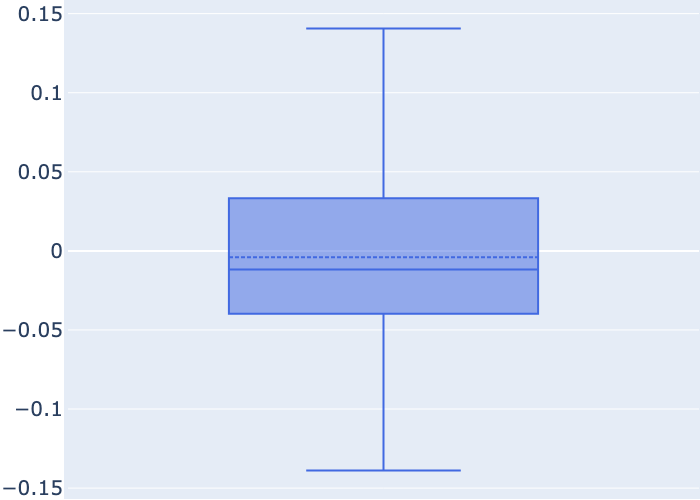

In [56]:
trace = box(y=rel_diff,
marker=attr(
        color="LightSkyBlue",
        size=1),
quartilemethod="linear",
name="",
marker_color="royalblue",
boxmean=true)

layout = Layout(
    autosize=false,
    width=500,
    height=500,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=20,
)
PlotlyJS.plot(trace,layout)

name = "emp_LS_HKPV"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

plt = PlotlyJS.plot(trace,layout)
PlotlyJS.savefig(plt,"figures/"*name*".pdf")

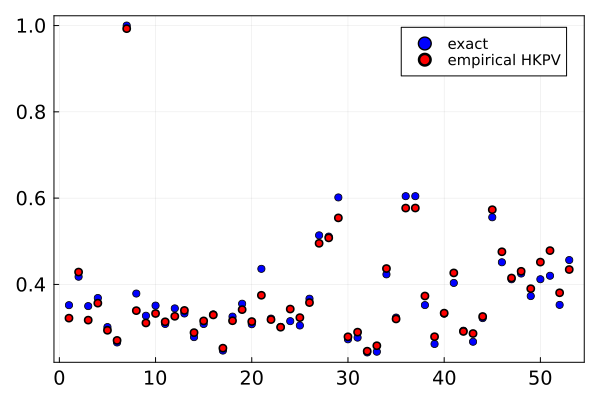

In [58]:

Plots.scatter(1:ne(meta_g),lev,label="exact", color=:blue,             
markersize=4,
xtickfont=font(13),
ytickfont=font(13),
guidefont=font(13),
legendfont=font(10),
framestyle=:box,
#size=(500, 500),
margins=0.1 * 2cm,);
# #
Plots.scatter!(1:ne(meta_g),emp_lev,label="empirical HKPV",                
markersize=4,
linewidth=2,
markerstrokewidth=2,
xtickfont=font(13),
ytickfont=font(13),
guidefont=font(13),
legendfont=font(10),
framestyle=:box,
#size=(500, 500),
margins=0.1 * 2cm,
color=:red)


##### Small graph with large inconsistenties

In [7]:
# common parameters
type="MUN"
rng = Random.default_rng()

# graph parameters
n = 20
p = 0.9

# regularization
q = 0

# planted ranking score
planted_score = randperm(rng,n)

# for MC evaluations
nb_samples = 100

eta = 0.9

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end
sparseB = sp_magnetic_incidence(meta_g; oriented=true);
n = nv(meta_g)

# regularization
q = 0

0

In [8]:
nb_edges = zeros(nb_samples)
nb_cc = zeros(nb_samples)


cc_with_1_cycle = zeros(nb_samples)
cc_with_0_cycle = zeros(nb_samples)
cc_with_more_than_1_cycle = zeros(nb_samples)

time_hkpv = zeros(nb_samples)
time_mtsf = zeros(nb_samples)

V = Matrix(qr(Matrix(sparseB)).Q)

for i_sample in 1:nb_samples

    id, t = @timed sample_pdpp(V)
    e = collect(edges(meta_g))
    subgraph,_ = induced_subgraph(meta_g, e[id])

    nb_edges[i_sample] = ne(subgraph)
    cc = connected_components(subgraph)

    nb_cc[i_sample] = length(cc)

    cc = [induced_subgraph(subgraph, cc)[1] for cc in connected_components(subgraph)]

    temp_cc_with_1_cycle = 0
    temp_cc_with_0_cycle = 0
    temp_cc_with_more_than_1_cycle = 0

    for i in cc
        l = length(cycle_basis(i))
        if l == 1
            temp_cc_with_1_cycle += 1
        elseif l == 0
            temp_cc_with_0_cycle += 1
        else
            temp_cc_with_more_than_1_cycle += 1
        end
    end

    cc_with_1_cycle[i_sample] = temp_cc_with_1_cycle
    cc_with_0_cycle[i_sample] = temp_cc_with_0_cycle
    cc_with_more_than_1_cycle[i_sample] = temp_cc_with_more_than_1_cycle

    time_hkpv[i_sample] = t
    mtsf, t_mtsf = @timed multi_type_spanning_forest(rng, meta_g, q)
    time_mtsf[i_sample] = t_mtsf

end    

println(cc_with_1_cycle)
println(cc_with_0_cycle)
println(cc_with_more_than_1_cycle)
println(" ")
println([mean(time_hkpv) mean(time_mtsf)])

[1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0

, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 
[0.0006312525399999999 0.00030051451]


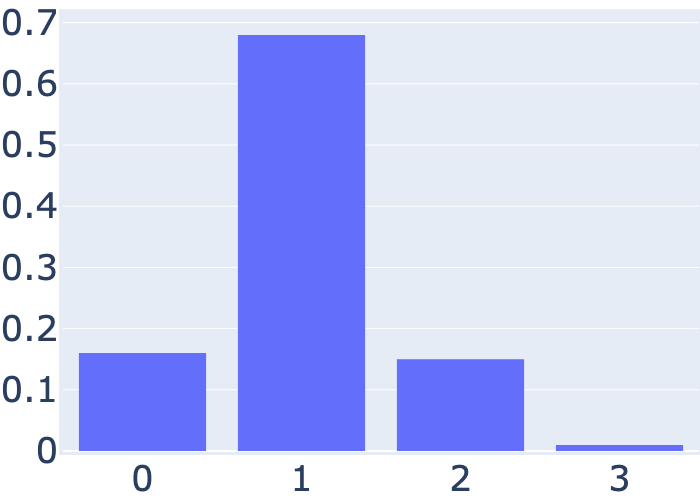

In [9]:
cat_nb_cc_1_cycle = string.(sort(Int.(cc_with_1_cycle)))
trace = PlotlyJS.histogram(x=cat_nb_cc_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
name = "comparison_hpkv_MUN_cc_with_1_cycle_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
p_1 = PlotlyJS.plot(trace,layout)


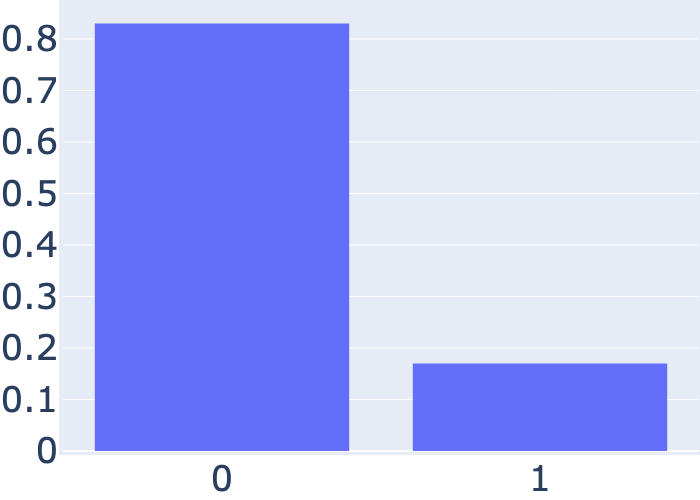

In [10]:
cat_nb_cc_with_more_than_1_cycle = string.(sort(Int.(cc_with_more_than_1_cycle
)))
trace = PlotlyJS.histogram(x=cat_nb_cc_with_more_than_1_cycle, histnorm="probability density")
layout = Layout(
    autosize=false,
    width=500,
    height=200,
    margin=attr(l=1, r=1, b=1, t=1, pad=4),
    font_size=35,
    xaxis_type="category",
)
name = "comparison_hpkv_MUN_cc_more_than_1_cycle_"*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)
p_more_than_1 = PlotlyJS.plot(trace,layout)
